#   Extended MNIST

The problem is a classification task to recognize the letters from the Extended MNIST dataset.

Three models have been developed:
- LeNet: adapted from the original LeNet to handle this task (26 output units and replaced sigmoid with ReLU)
- Custom Neural Network
- Custom Convolutional Neural Network

The custom models have been created using `keras_tuner` to find the best architecture

Once the best configuration has been determined, each model has been trained with all the training set and evaluated on the testing set

## Initialization

The following cell loads and configures basic libraries and the dataset which is split into _training_, _validation_ and _testing_ (60%, 20%, 20%)

It creates the sets used by the CNN (by adding another dimension to represent the single channel)  
It also creates the sets used by the final model (_training_ + _validation_)

Some helper functions are also defined to plot history (and save it to a file) and to write a `dict` to file

In [19]:
# Import basic libraries
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import keras_tuner as kt
import json

# Set seed
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.ioff() # disable interactive mode (display figure only if plt.show() is called; not when saving to file)

# Read dataset
df = pd.read_csv("emnist-letters.csv")

# Reshape to images to matrices 28x28 (like an image)
X = df.iloc[:,1:].to_numpy().reshape(-1, 28, 28, order="F") # skipping the first column as it is the label
y = df.iloc[:,0].to_numpy()-1                               # considering only the first column

# Split dataset in training and testing (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split training set in training and validation (75% of 80% in training and 25% of 80% in validation)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Normalize (to have values between 0 and 1)
X_train = X_train.astype("float32") / 255.
X_valid = X_valid.astype("float32") / 255.
X_test = X_test.astype("float32") / 255.

# Reshape with single channel (used by CNN); images are gryscale, so only one channel is needed
X_train_cnn = X_train.reshape(-1, 28, 28, 1)
X_valid_cnn = X_valid.reshape(-1, 28, 28, 1)
X_test_cnn = X_test.reshape(-1, 28, 28, 1)

# Create a set with training and validation (used when training the final model, with the number of iteration found by early stopping)
X_train_final = np.concatenate((X_train, X_valid))
X_train_cnn_final = X_train_final.reshape(-1, 28, 28, 1)
y_train_final = np.concatenate((y_train, y_valid))

# Dataset is split: 60% in training, 20% in validation and 20% in testing
print(f"Dataset size: {df.shape[0]}; Training size: {X_train.shape[0]}; Validation size: {X_valid.shape[0]}; Testing size: {X_test.shape[0]}")

# Helper function to plot model history (used to determine the number of epochs)
def plot_history(history):
  pd.DataFrame(history.history).plot(figsize=(8, 5))
  plt.grid(True)
  plt.gca().set_ylim(0, 1)
  plt.show()

def save_plot_history(history, name):
  pd.DataFrame(history.history).plot(figsize=(8, 5))
  plt.grid(True)
  plt.gca().set_ylim(0, 1)
  plt.savefig(name)
  return

def save_best_hp(data, name):
  with open(name, 'w') as fp:
    json.dump(data, fp, indent=2)

Dataset size: 88799; Training size: 53279; Validation size: 17760; Testing size: 17760


## LeNet-5

Adapted version of LeNet-5 (using ReLU as activation function, and 26 units in output layer)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

2024-01-26 14:25:32.555910: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
1665/1665 [==============================] - 17s 10ms/step - loss: 0.7414 - accuracy: 0.7723 - val_loss: 0.4222 - val_accuracy: 0.8640
Epoch 2/50
1665/1665 [==============================] - 16s 10ms/step - loss: 0.3441 - accuracy: 0.8864 - val_loss: 0.3240 - val_accuracy: 0.8939
Epoch 3/50
1665/1665 [==============================] - 16s 10ms/step - loss: 0.2762 - accuracy: 0.9069 - val_loss: 0.3131 - val_accuracy: 0.9002
Epoch 4/50
1665/1665 [==============================] - 16s 10ms/step - loss: 0.2373 - accuracy: 0.9193 - val_loss: 0.2541 - val_accuracy: 0.9173
Epoch 5/50
1665/1665 [==============================] - 16s 9ms/step - loss: 0.2112 - accuracy: 0.9260 - val_loss: 0.2480 - val_accuracy: 0.9211
Epoch 6/50
1665/1665 [==============================] - 16s 9ms/step - loss: 0.1914 - accuracy: 0.9321 - val_loss: 0.2513 - val_accuracy: 0.9188
Epoch 7/50
1665/1665 [==============================] - 16s 9ms/step - loss: 0.1760 - accuracy: 0.9367 - val_loss: 0.2383 - va

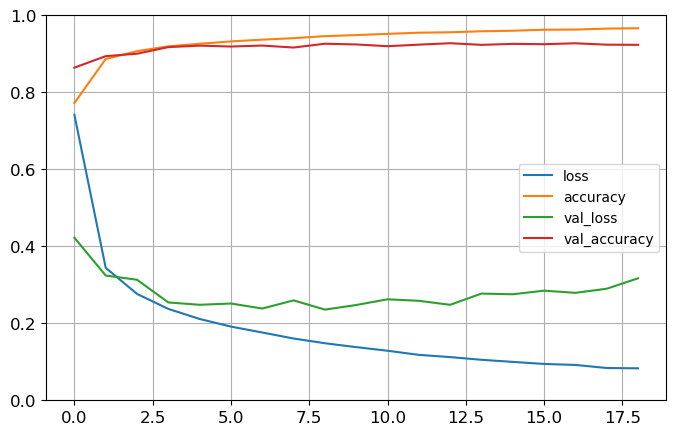

In [2]:
lenet = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='relu', padding='same', input_shape=(28, 28, 1)),
            tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
            tf.keras.layers.Conv2D(filters=16, kernel_size=5,activation='relu'),
            tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(120, activation='relu'),
            tf.keras.layers.Dense(84, activation='relu'),
            tf.keras.layers.Dense(26, activation="softmax")])

lenet.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

lenet.summary()

history_lenet = lenet.fit(X_train_cnn, y_train, epochs=50,
                          validation_data=(X_valid_cnn, y_valid),
                          callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

plot_history(history_lenet)

In [4]:
epochs = 8
# Retrain on all the training set
final_lenet = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='relu', padding='same', input_shape=(28, 28, 1)),
            tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
            tf.keras.layers.Conv2D(filters=16, kernel_size=5,activation='relu'),
            tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(120, activation='relu'),
            tf.keras.layers.Dense(84, activation='relu'),
            tf.keras.layers.Dense(26, activation="softmax")])

final_lenet.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

final_lenet.summary()

final_lenet.fit(X_train_cnn_final, y_train_final, epochs=epochs)

# Evaluate with testing set
results = final_lenet.evaluate(X_test_cnn, y_test)
print(f'Test Loss: {results[0]}; Test Accuracy: {results[1]}')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d_4 (Averag  (None, 14, 14, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_5 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten_2 (Flatten)         (None, 400)               0         
                                                                 
 dense_6 (Dense)             (None, 120)              

## Custom Neural Network



In [2]:
def build_model(hp):
  model = tf.keras.models.Sequential()
  # input layer (flatten images to 1D vector)
  model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))

  # choose dropout rate in range [0.1, 0.3]
  dropoutRate1 = hp.Float('dropoutRate1', min_value=0.1, max_value=0.3, step=0.1)
  dropoutRate2 = hp.Float('dropoutRate2', min_value=0.1, max_value=0.3, step=0.1)
  dropoutRate3 = hp.Float('dropoutRate3', min_value=0.1, max_value=0.3, step=0.1)
  # decide whether to add dropout
  if hp.Boolean('dropout'):
    model.add(tf.keras.layers.Dropout(rate=dropoutRate1))
  
  # add hidden layer
  model.add(tf.keras.layers.Dense(
    units=hp.Int('units1', min_value=50, max_value=300, step=10),
    activation=hp.Choice('activation1', ['relu', 'leaky_relu', 'tanh']),
  ))

  # add second hidden layer if enabled
  if hp.Boolean('layer2'):
    if hp.Boolean('dropout2'):
      model.add(tf.keras.layers.Dropout(rate=dropoutRate2))
    model.add(tf.keras.layers.Dense(
      units=hp.Int('units2', min_value=20, max_value=100, step=10),
      activation=hp.Choice('activation2', ['relu', 'leaky_relu', 'tanh'])
    ))

    # add third layer if enabled
    if hp.Boolean('layer3'):
      if hp.Boolean('dropout3'):
        model.add(tf.keras.layers.Dropout(rate=dropoutRate3))
      model.add(tf.keras.layers.Dense(
        units=hp.Int('units3', min_value=10, max_value=50, step=10),
        activation=hp.Choice('activation3', ['relu', 'leaky_relu', 'tanh'])
      ))

  # output layer
  model.add(tf.keras.layers.Dense(26, activation='softmax'))
  # compile the model using Cross Entropy as Loss and Adam (with default parameters) as the optimizer
  model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
  )
  return model

In [3]:
# Create the tuner
tuner = kt.Hyperband(
  hypermodel=build_model,
  objective='val_accuracy',
  overwrite=True,
  directory='/tmp/emnist',
  project_name='emnist-nn',
  seed=42
)

tuner.search_space_summary()

# Search the best NN using training and validation sets
tuner.search(X_train, y_train, 
             validation_data=(X_valid, y_valid),
             epochs=50,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

Trial 254 Complete [00h 03m 14s]
val_accuracy: 0.8895270228385925

Best val_accuracy So Far: 0.9059121608734131
Total elapsed time: 03h 06m 44s


In [5]:
# Best hyper-parameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)
save_best_hp(best_hps.values, 'nn.json') # saving to json file

{'dropoutRate1': 0.2, 'dropoutRate2': 0.1, 'dropoutRate3': 0.1, 'dropout': True, 'units1': 240, 'activation1': 'relu', 'layer2': True, 'dropout2': True, 'units2': 70, 'activation2': 'relu', 'layer3': False, 'dropout3': True, 'units3': 20, 'activation3': 'leaky_relu', 'tuner/epochs': 100, 'tuner/initial_epoch': 34, 'tuner/bracket': 4, 'tuner/round': 4, 'tuner/trial_id': '0142'}


Model: "sequential_11"
_________________________________________________________________


 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 784)               0         
                                                                 
 dropout_22 (Dropout)        (None, 784)               0         
                                                                 
 dense_33 (Dense)            (None, 240)               188400    
                                                                 
 dropout_23 (Dropout)        (None, 240)               0         
                                                                 
 dense_34 (Dense)            (None, 70)                16870     
                                                                 
 dense_35 (Dense)            (None, 26)                1846      
                                                                 
Total params: 207,116
Trainable params: 207,116
Non-trainable params: 0
_________________________________________________________________
None

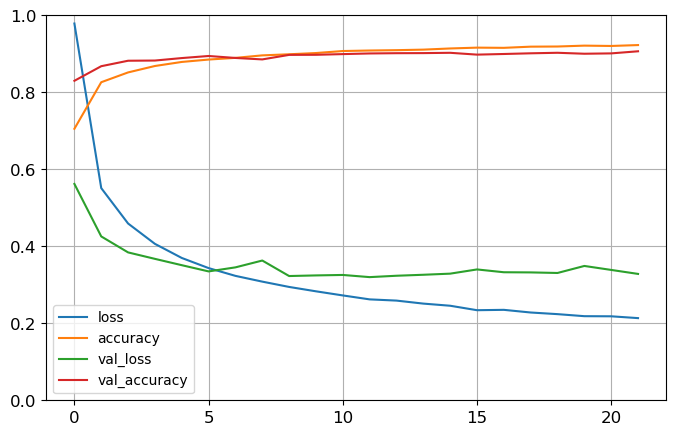

In [20]:
# Building the best model to determine the number of epochs to train
model = tuner.hypermodel.build(best_hps)
print(model.summary()) # print the best model
history_nn = model.fit(X_train, y_train, 
                       validation_data=(X_valid, y_valid),
                       epochs=100,
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])
plot_history(history_nn)
save_plot_history(history_nn, 'nn.png')

In [21]:
epochs = 20

# Build final NN
nn_final = tf.keras.models.Sequential()
nn_final.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
nn_final.add(tf.keras.layers.Dropout(rate=0.2))
nn_final.add(tf.keras.layers.Dense(240, activation="relu", kernel_initializer=tf.keras.initializers.HeNormal(seed=42)))
nn_final.add(tf.keras.layers.Dropout(rate=0.1))
nn_final.add(tf.keras.layers.Dense(70, activation="relu", kernel_initializer=tf.keras.initializers.HeNormal(seed=42)))
nn_final.add(tf.keras.layers.Dense(26, activation="softmax", kernel_initializer=tf.keras.initializers.HeNormal(seed=42)))

nn_final.summary()
nn_final.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
nn_final.fit(X_train_final, y_train_final, epochs=epochs)

# Evaluate with testing set
results = nn_final.evaluate(X_test, y_test)
print(f'Test Loss: {results[0]}; Test Accuracy: {results[1]}')

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_12 (Flatten)        (None, 784)               0         
                                                                 
 dropout_24 (Dropout)        (None, 784)               0         
                                                                 
 dense_36 (Dense)            (None, 240)               188400    
                                                                 
 dropout_25 (Dropout)        (None, 240)               0         
                                                                 
 dense_37 (Dense)            (None, 70)                16870     
                                                                 
 dense_38 (Dense)            (None, 26)                1846      
                                                                 
Total params: 207,116
Trainable params: 207,116
Non-t

## Convolutional Neural Network (custom)

In [4]:
def build_cnn_model(hp):
  model = tf.keras.models.Sequential()
  
  # determine the best parameters for the first convolutional layer
  cnn_activation_1 = hp.Choice('activation', ['relu', 'leaky_relu', 'tanh'])
  filters1 = hp.Int('filters1', min_value=1, max_value=10, step=1)
  kernel1 = hp.Int('size1', min_value=1, max_value=9, step=2)
  model.add(tf.keras.layers.Conv2D(filters=filters1, kernel_size=kernel1, activation=cnn_activation_1, padding='same', input_shape=(28, 28, 1)))

  # determine the stride (and window size) for the Max/Avg pooling layer
  stride1 = hp.Int('stride1', min_value=2, max_value=4, step=2)
  if hp.Boolean('avg1'): # choose between max or avg pooling
    model.add(tf.keras.layers.AveragePooling2D(pool_size=stride1, strides=stride1))
  else:
    model.add(tf.keras.layers.MaxPooling2D(pool_size=stride1, strides=stride1))
  
  # add second convolutional layer if enabled
  if hp.Boolean('hidden1'):
    cnn_activation_2 = hp.Choice('activation', ['relu', 'leaky_relu', 'tanh'])
    filters2 = hp.Int('filters2', min_value=1, max_value=10, step=1)
    kernel2 = hp.Int('size2', min_value=1, max_value=9, step=2)
    model.add(tf.keras.layers.Conv2D(filters=filters2, kernel_size=kernel2, activation=cnn_activation_2, padding='same'))

    stride2 = hp.Int('stride2', min_value=2, max_value=4, step=2)
    if hp.Boolean('avg2'): # choose between max or avg pooling
      model.add(tf.keras.layers.AveragePooling2D(pool_size=stride2, strides=stride2))
    else:
      model.add(tf.keras.layers.MaxPooling2D(pool_size=stride2, strides=stride2))

    # add third convolutional layer if enabled
    if hp.Boolean('hidden2'):
      cnn_activation_3 = hp.Choice('activation', ['relu', 'leaky_relu', 'tanh'])
      filters3 = hp.Int('filters3', min_value=1, max_value=10, step=1)
      kernel3 = hp.Int('size3', min_value=1, max_value=9, step=2)
      model.add(tf.keras.layers.Conv2D(filters=filters3, kernel_size=kernel3, activation=cnn_activation_3, padding='same'))

      stride3 = hp.Int('stride3', min_value=2, max_value=4, step=2)
      if hp.Boolean('avg3'): # choose between max or avg pooling
        model.add(tf.keras.layers.AveragePooling2D(pool_size=stride3, strides=stride3))
      else:
        model.add(tf.keras.layers.MaxPooling2D(pool_size=stride3, strides=stride3))
  
  # flatten to 1D vector, so a dense layer can be used
  model.add(tf.keras.layers.Flatten())
  # add dense layer if enabled
  if hp.Boolean('dense'):
    model.add(tf.keras.layers.Dense(
      units=hp.Int('units', min_value=30, max_value=100, step=10),
      activation=hp.Choice('act_dense', ['relu', 'leaky_relu', 'tanh']),
    ))
    # add second dense layer if enabled
    if hp.Boolean('dense2'):
      model.add(tf.keras.layers.Dense(
        units=hp.Int('units2', min_value=30, max_value=100, step=10),
        activation=hp.Choice('act_dense2', ['relu', 'leaky_relu', 'tanh']),
      ))
  # output layer (softmax with 26 outputs)
  model.add(tf.keras.layers.Dense(26, activation='softmax'))

  # compile the model
  model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
  )
  return model

In [5]:
# create the tuner
cnn_tuner = kt.Hyperband(
  hypermodel=build_cnn_model,
  objective='val_accuracy',
  overwrite=True,
  directory='/tmp/emnist-tuner',
  project_name='emnist-cnn',
  seed=42
)

cnn_tuner.search_space_summary()

# search the best model
cnn_tuner.search(X_train_cnn, y_train,
                 validation_data=(X_valid_cnn, y_valid),
                 epochs=50,
                 callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

Trial 164 Complete [00h 00m 37s]
val_accuracy: 0.8734797239303589

Best val_accuracy So Far: 0.9179617166519165
Total elapsed time: 01h 27m 25s

Search: Running Trial #165

Value             |Best Value So Far |Hyperparameter
relu              |relu              |activation
1                 |9                 |filters1
5                 |7                 |size1
4                 |2                 |stride1
True              |True              |avg1
True              |False             |hidden1
False             |True              |hidden2
True              |True              |dense
4                 |5                 |filters3
7                 |9                 |size3
4                 |2                 |stride3
True              |True              |avg3
70                |40                |units
leaky_relu        |leaky_relu        |act_dense
False             |False             |dense2
5                 |1                 |filters2
5                 |9                 |size2
2

KeyboardInterrupt: 

In [4]:
# Best hyper-parameters
best_hps_cnn = cnn_tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps_cnn.values)
save_best_hp(best_hps.values, 'cnn.json') # save hyper-parameters to cnn.json

{'activation': 'leaky_relu', 'filters1': 8, 'size1': 7, 'stride1': 2, 'avg1': True, 'hidden1': False, 'hidden2': True, 'dense': True, 'filters3': 6, 'size3': 7, 'stride3': 2, 'avg3': False, 'units': 60, 'act_dense': 'leaky_relu', 'filters2': 5, 'size2': 7, 'stride2': 4, 'avg2': True, 'tuner/epochs': 34, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}


Epoch 1/100
1665/1665 [==============================] - 23s 13ms/step - loss: 1.1716 - accuracy: 0.6444 - val_loss: 0.6715 - val_accuracy: 0.7869
Epoch 2/100
1665/1665 [==============================] - 25s 15ms/step - loss: 0.5691 - accuracy: 0.8219 - val_loss: 0.5091 - val_accuracy: 0.8360
Epoch 3/100
1665/1665 [==============================] - 27s 16ms/step - loss: 0.4541 - accuracy: 0.8544 - val_loss: 0.4533 - val_accuracy: 0.8525
Epoch 4/100
1665/1665 [==============================] - 28s 17ms/step - loss: 0.3948 - accuracy: 0.8737 - val_loss: 0.3743 - val_accuracy: 0.8785
Epoch 5/100
1665/1665 [==============================] - 28s 17ms/step - loss: 0.3546 - accuracy: 0.8848 - val_loss: 0.3438 - val_accuracy: 0.8903
Epoch 6/100
1665/1665 [==============================] - 27s 16ms/step - loss: 0.3272 - accuracy: 0.8950 - val_loss: 0.3266 - val_accuracy: 0.8940
Epoch 7/100
1665/1665 [==============================] - 26s 16ms/step - loss: 0.3080 - accuracy: 0.9013 - val_loss: 0

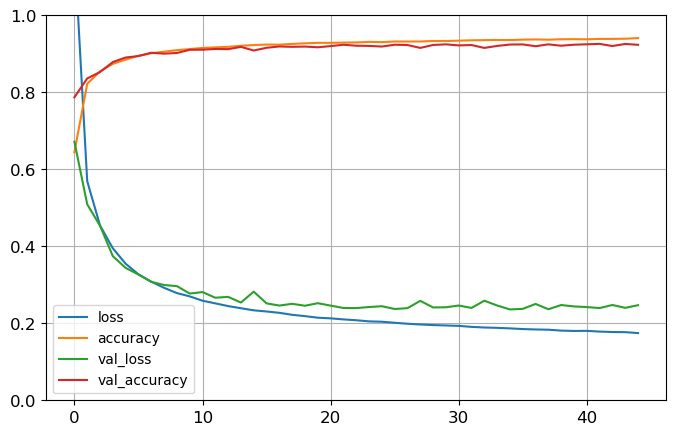

In [17]:
# build model with best hyper parameter to determine the number of epochs
cnn_model = cnn_tuner.hypermodel.build(best_hps_cnn)
print(cnn_model.summary())
history_cnn = cnn_model.fit(X_train_cnn, y_train, 
                       validation_data=(X_valid_cnn, y_valid),
                       epochs=100,
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])
plot_history(history_cnn)
save_plot_history(history_cnn, 'cnn.png')

In [6]:
epochs = 45
# Retrain on all the training set
final_cnn = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(filters=8, kernel_size=7, activation='leaky_relu', padding='same', input_shape=(28, 28, 1), kernel_initializer=tf.keras.initializers.HeNormal(seed=42)),
            tf.keras.layers.AveragePooling2D(pool_size=2, strides=2),
            tf.keras.layers.Conv2D(filters=6, kernel_size=7,activation='leaky_relu', kernel_initializer=tf.keras.initializers.HeNormal(seed=42)),
            tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(60, activation='leaky_relu', kernel_initializer=tf.keras.initializers.HeNormal(seed=42)),
            tf.keras.layers.Dense(26, activation="softmax", kernel_initializer=tf.keras.initializers.HeNormal(seed=42))])

final_cnn.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

final_cnn.summary()

final_cnn.fit(X_train_cnn_final, y_train_final, epochs=epochs)

# Evaluate with testing set
results = final_cnn.evaluate(X_test_cnn, y_test)
print(f'Test Loss: {results[0]}; Test Accuracy: {results[1]}')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 8)         400       
                                                                 
 average_pooling2d_2 (Averag  (None, 14, 14, 8)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 6)           2358      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 6)          0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 96)                0         
                                                                 
 dense_2 (Dense)             (None, 60)               